# <font color=red>Estimating homography</font>

This jupyter notebook is a porting of lab1 written in Matlab using opencv and python3.

In this example we will estimate homographies from a set of checkboard images.
Estimating homographies is the first step of the Zhang's calibration method.

<b>Table of Contents</b>
* Load and display images
* Detect checkerboard points
* Visualizing the detected points
* Processing many images
* Establishing correspondences
* Estimating homographies
* Superimposing a circle to the checkerboard
* Homework


## Load and display images
Let the images be located in a subfolder of the current folder called images.

Original code:




In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
I = cv2.imread('../images/Image11.tif')
images = glob.glob('../images/*.tif')

Let's check the size and type of the data

In [2]:
print("Shape: ",I.shape)
print("Type: ",type(I))
print("Data type: ",I.dtype)

Shape:  (480, 640, 3)
Type:  <class 'numpy.ndarray'>
Data type:  uint8


Visualize the image:

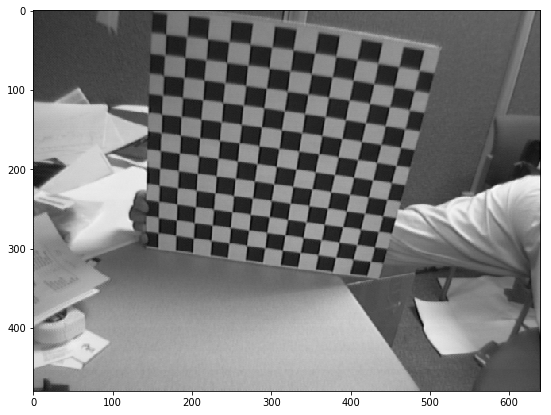

In [3]:


plt.figure(figsize=(15, 7))
imgplot = plt.imshow(I)




## Detect checkerboard points
To estimate homographies, we need a set of correspondences (at least four) between 3D points lying on the checkerboard pattern and 2D points in the image. The size of the squares of the pattern is 30mm. A function is available in the Computer Vision Toolbox, for detecting the checkerboard points:

True
(144, 1, 2)


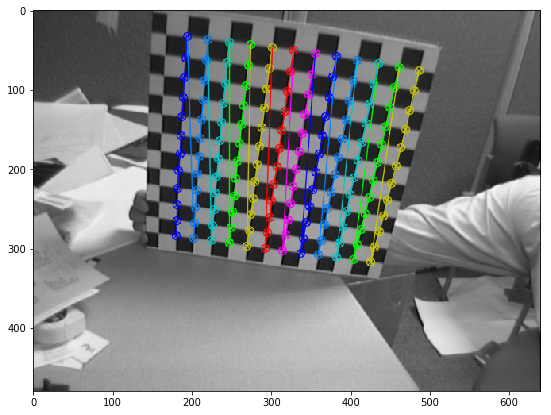

In [4]:
columns=12
rows=12

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((columns*rows,3), np.float32)
objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


# Find the chess board corners
ret, corners = cv2.findChessboardCorners(I, (rows,columns),None)
print(ret)
# If found, add object points, image points (after refining them)
if ret == True:
    print(corners.shape)

    objpoints.append(objp)

    corners2 = cv2.cornerSubPix(I[:,:,0],corners,(rows,columns),(-1,-1),criteria)
    imgpoints.append(corners2)

    # Draw and display the corners
    img = cv2.drawChessboardCorners(I, (rows,columns), corners2,ret)
    plt.figure(figsize=(15, 7))
    imgplot = plt.imshow(img)



In this case it seems that Matlab performs better, since it finds 13 * 14 square intersections

## Multiple images


In [5]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


In [6]:

def findCornersAllImages(criteria,rows,columns,plot=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((columns*rows,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    #check every image
    cont=0
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (rows,columns),None)
        #print(fname,ret)
        # If found, add object points, image points (after refining them)
        if ret == True:
            cont+=1
            print(fname,corners.shape)

            objpoints.append(objp)


            corners2 = cv2.cornerSubPix(gray,corners,(rows,columns),(-1,-1),criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            if (plot==True):
                img_chess = cv2.drawChessboardCorners(img, (rows,columns), corners2,ret)
                plt.figure(figsize=(15, 7))
                imgplot = plt.imshow(img_chess)
            #print("Number of detections: ",str(cont)," columns: ",str(columns), "rows: ",str(rows))                    
    return objpoints,imgpoints,gray



../images/Image11.tif (156, 1, 2)
../images/Image17.tif (156, 1, 2)
../images/Image9.tif (156, 1, 2)
../images/Image10.tif (156, 1, 2)
../images/Image20.tif (156, 1, 2)


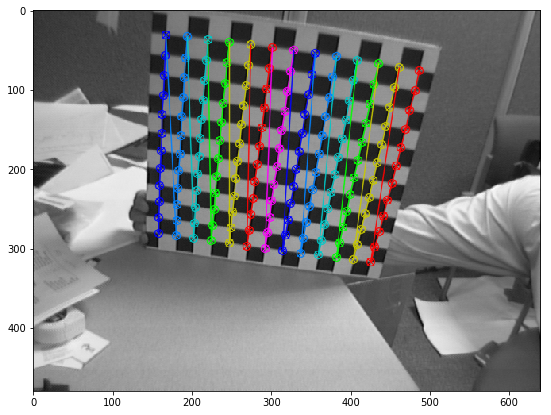

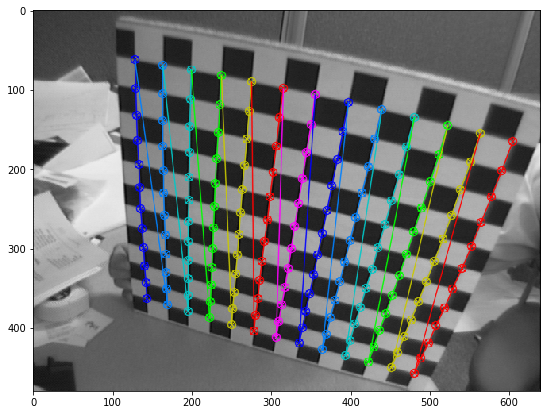

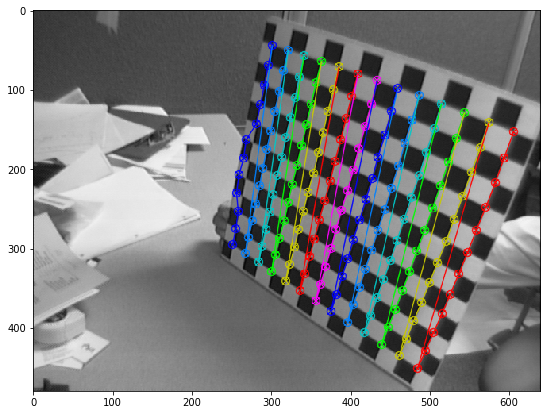

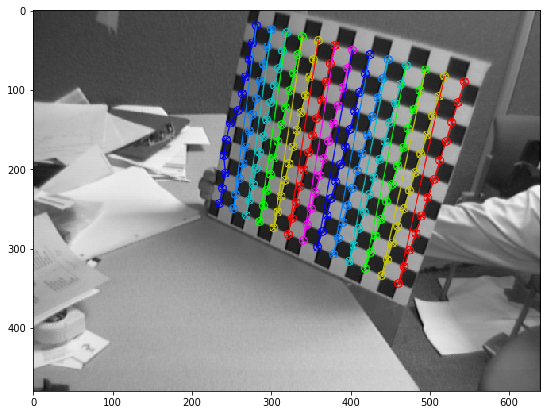

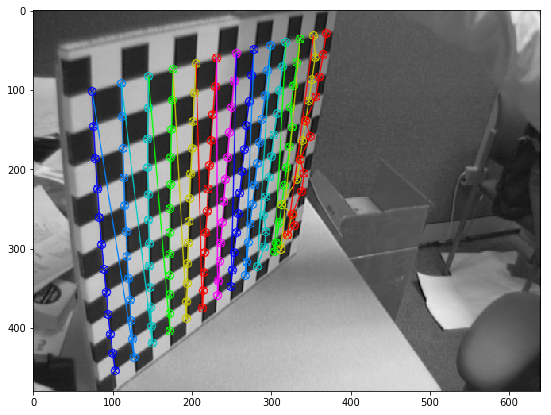

In [7]:
objpoints,imgpoints,gray = findCornersAllImages(criteria,12,13,True)

None


##  Calibration



In [8]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print(ret)


1.5114311164158938


In [9]:


print("Type: ",type(objpoints[1]))
print(len(objpoints[1]))

Type:  <class 'numpy.ndarray'>
156


0.08599242
0.10447802
0.39165545
0.28218895
1.0583379


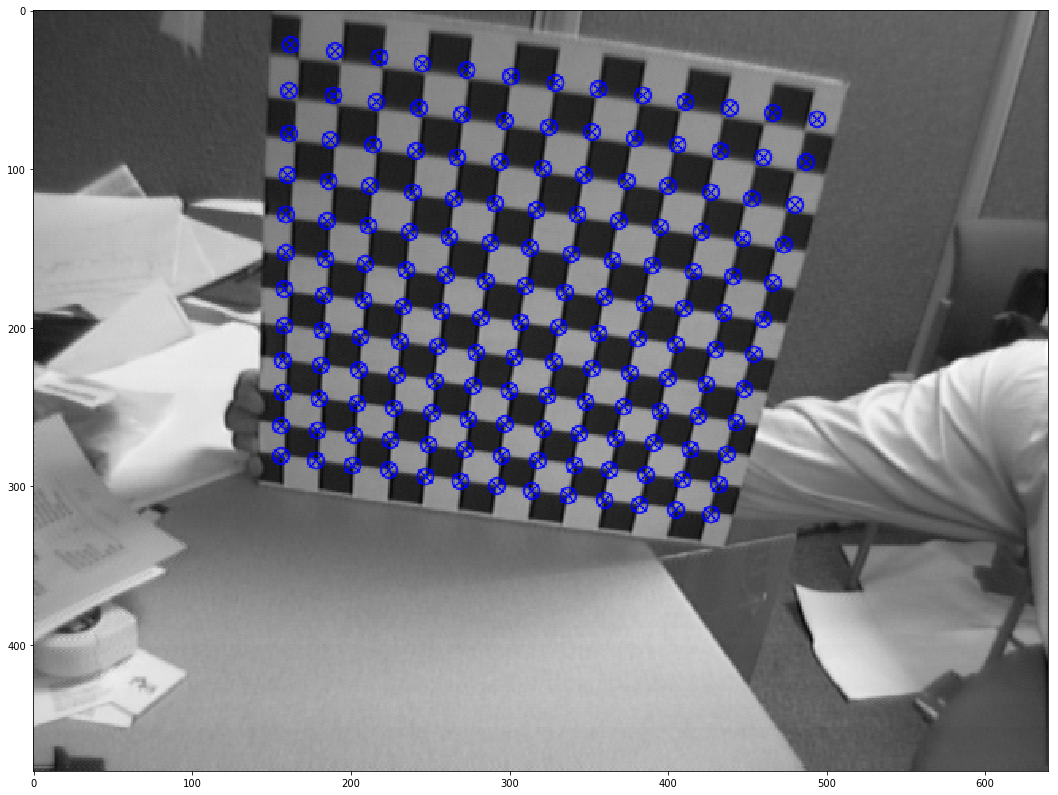

In [45]:
#let's compute the mean error of the reprojection considering for radial distortion
for i in range(0,5):
    points_1=cv2.projectPoints(objpoints[i],rvecs[i],tvecs[i],mtx,dist)
    err= abs(imgpoints[i]-points_1[0])
    print(err.mean())
    
I = cv2.imread('../images/Image11.tif')
#Let's plot them back on the image
points_1=cv2.projectPoints(objpoints[0],rvecs[0],tvecs[0],mtx,dist1)
img_chess1 = cv2.drawChessboardCorners(I, (rows,columns), points_1[0],False)
plt.figure(figsize=(30, 14))
imgplot = plt.imshow(img_chess1)

1.3980973
2.6218238
2.672173
1.9805793
2.7343538


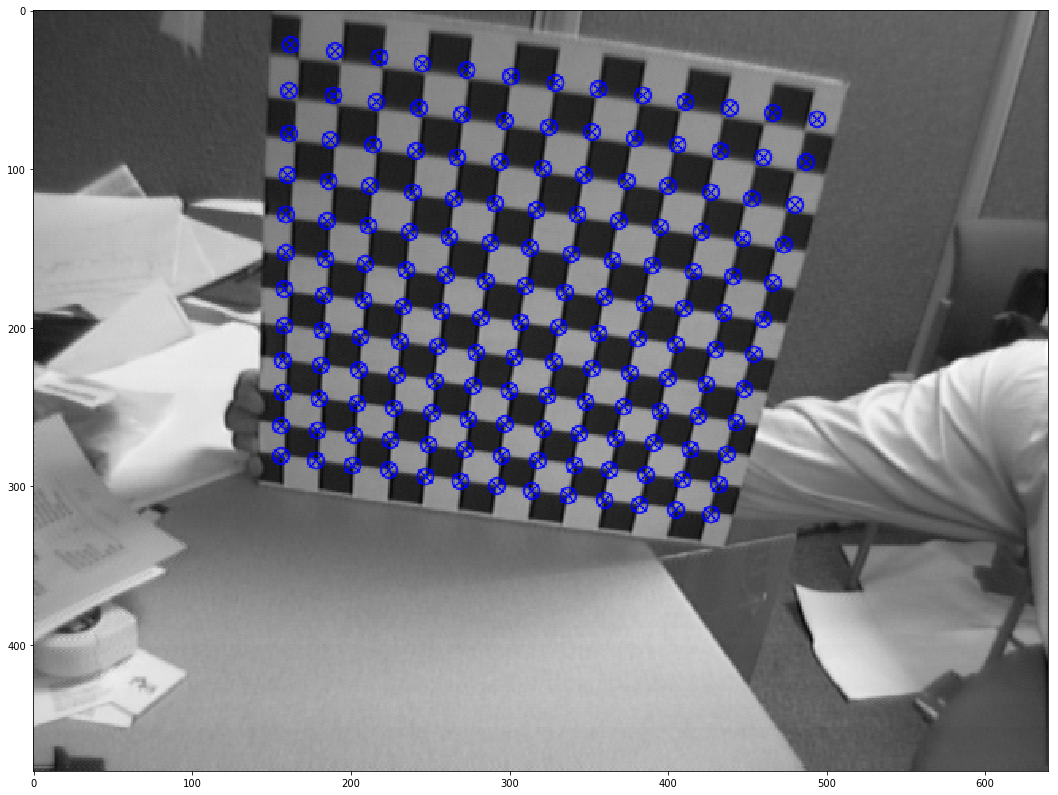

In [46]:
#without radial distortion 
dist1=np.zeros((dist.size))
for i in range(0,5):
    points_1=cv2.projectPoints(objpoints[i],rvecs[i],tvecs[i],mtx,dist1)
    err= abs(imgpoints[i]-points_1[0])
    print(err.mean())
    
I = cv2.imread('../images/Image11.tif')
#Let's plot them back on the image
points_1=cv2.projectPoints(objpoints[0],rvecs[0],tvecs[0],mtx,dist1)
img_chess1 = cv2.drawChessboardCorners(I, (rows,columns), points_1[0],False)
plt.figure(figsize=(30, 14))
imgplot = plt.imshow(img_chess1)

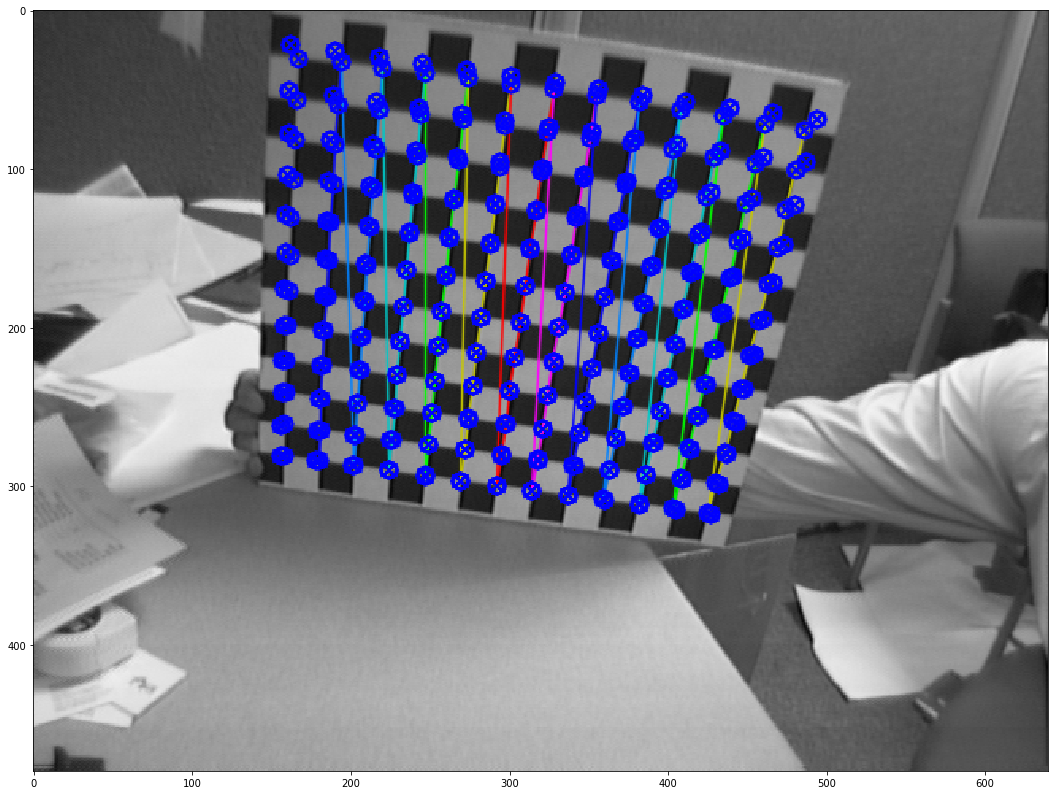

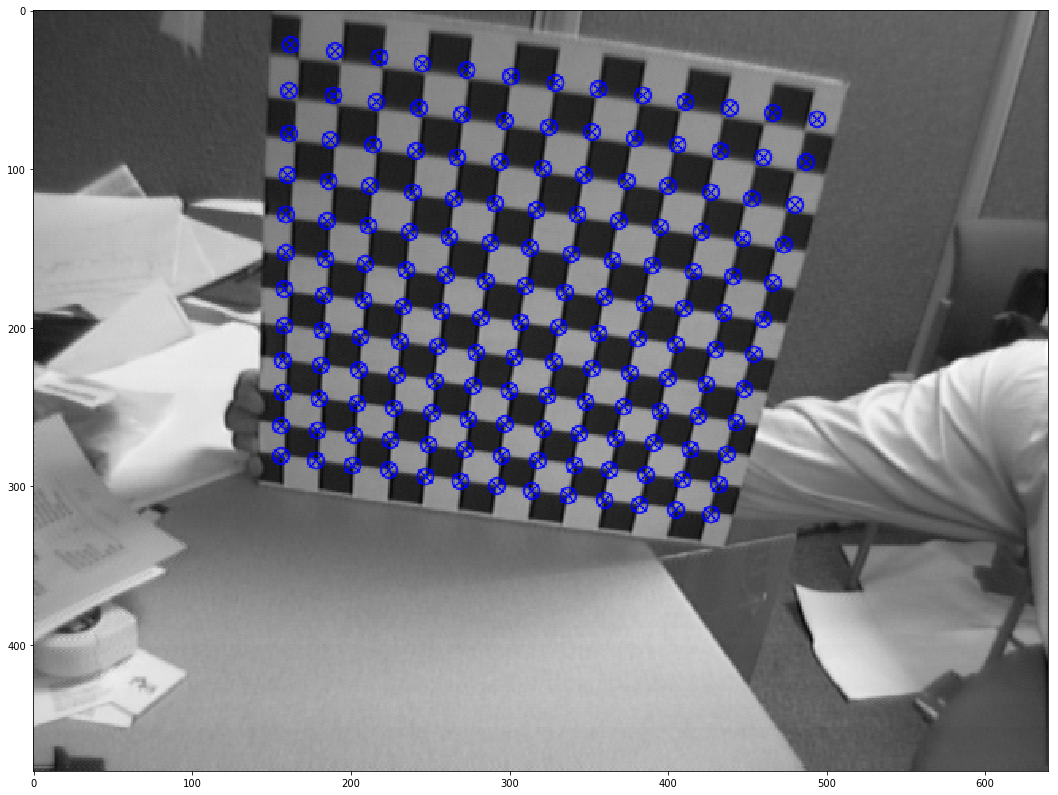

In [ ]:
CV_CALIB_USE_INTRINSIC_GUESS = mtx
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None,CV_CALIB_USE_INTRINSIC_GUESS)
print(ret)

## Draw axis


In [ ]:
objp

In [ ]:


def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img



#Augmented reality

axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (rows,columns),None)
    print(fname,ret)
    # If found, add object points, image points (after refining them)
    if ret == True:
        print(fname,corners.shape)
        corners2 = cv2.cornerSubPix(gray,corners,(rows,columns),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        retval, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)

       
        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

        # Draw and display the corners
        img = draw(img,corners2,imgpts)
        plt.figure(figsize=(15, 7))
        imgplot = plt.imshow(img)

        








## Draw a cube

In [ ]:


def draw_cube(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)

    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)

    return img



#Augmented reality

axis = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
                   [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3] ])
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (rows,columns),None)
    #print(fname,ret)
    # If found, add object points, image points (after refining them)
    if ret == True:
        print(fname,corners.shape)
        corners2 = cv2.cornerSubPix(gray,corners,(rows,columns),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        retval, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)

       
        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

        # Draw and display the corners
        img = draw_cube(img,corners2,imgpts)
        plt.figure(figsize=(15, 7))
        imgplot = plt.imshow(img)

        






